# Libraries

In [1]:
# General
import pandas as pd
import numpy as np

# Data Management
from dataclasses import dataclass, field
from collections import namedtuple
from typing import List, Any
import pickle

# Graphing
import matplotlib.pyplot as plt

# Data Import

In [2]:
def import_smhi(path, skiprows, usecols, rename):
    df = pd.read_csv(
        path,
        skiprows = skiprows, sep = ";", parse_dates = True,
        usecols = usecols
        )
    df.columns = rename
    df["date"] = pd.to_datetime(df["date"]) # Convert to datetimes
    return df

def import_fmi(path, skiprows, usecols, rename):
    #converters = {col: convert_dashes for col in usecols}  # Apply convert_dashes to each column in usecols
    df = pd.read_csv(
        path,
        skiprows = skiprows, sep = ",", parse_dates = True,
        usecols = usecols,
    #    converters = converters
    na_values = "-"
        )
    df.columns = rename
    #df["date"] = pd.to_datetime(df[["year", "month", "day"]]) # Convert to datetimes
    return df

## Import

In [3]:
# Arctic Atmospheric Indices (NAO and AO)
nao = pd.read_csv("../data/raw/atmosphere/nao/norm.daily.nao.cdas.z500.19500101_current.csv").rename(columns = {"nao_index_cdas": "nao"})
ao = pd.read_csv("../data/raw/atmosphere/ao/norm.daily.ao.cdas.z1000.19500101_current.csv").rename(columns = {"ao_index_cdas": "ao"})

# SMHI - Swedish Meteorological Institute Data for Abisko-Stordalen Palsa Bog
# We're importing both the manual and automatic station data. Why? The auto station data has lots of data gaps but runs to present day. The manual has less data gaps but stops in about 2022. We'll merge them in a bit.
# Quality Flag:
# Green (G) = Checked and approved values.
# Yellow (Y) = Suspicious or aggregated values. Roughly checked archival data and unchecked real-time data (last 2 hours).

se_sto_precip_manual = import_smhi(
    path = "../data/raw/climate/abisko-stordalen-palsa-bog/precipitation/smhi-opendata_5_188800_20250418_163156.csv",
    skiprows = 9,
    usecols = ["Representativt dygn", "Nederbördsmängd", "Kvalitet"],
    rename = ["date", "precipitation", "quality_flag"]
)
se_sto_precip_auto = import_smhi(
    path = "../data/raw/climate/abisko-stordalen-palsa-bog/precipitation/smhi-opendata_5_188790_20250418_163211.csv",
    skiprows = 9,
    usecols = ["Representativt dygn", "Nederbördsmängd", "Kvalitet"],
    rename = ["date", "precipitation", "quality_flag"]
)
se_sto_temp_manual = import_smhi(
    path = "../data/raw/climate/abisko-stordalen-palsa-bog/temperature/smhi-opendata_2_188800_20250418_130808.csv",
    skiprows = 9,
    usecols = ["Representativt dygn", "Lufttemperatur", "Kvalitet"],
    rename = ["date", "temperature", "quality_flag"]
)
se_sto_temp_auto = import_smhi(
    path = "../data/raw/climate/abisko-stordalen-palsa-bog/temperature/smhi-opendata_2_188790_20250418_130625.csv",
    skiprows = 9,
    usecols = ["Representativt dygn", "Lufttemperatur", "Kvalitet"],
    rename = ["date", "temperature", "quality_flag"]
)
se_sto_snowdepth_manual = import_smhi(
    path = "../data/raw/climate/abisko-stordalen-palsa-bog/snowdepth/smhi-opendata_8_40_188800_20250418_164039.csv",
    skiprows = 9,
    usecols = ["Datum", "Snödjup", "Kvalitet"],
    rename = ["date", "snowdepth", "quality_flag"]
)
se_sto_snowdepth_auto = import_smhi(
    path = "../data/raw/climate/abisko-stordalen-palsa-bog/snowdepth/smhi-opendata_8_40_188790_20250418_164059.csv",
    skiprows = 11,
    usecols = ["Datum", "Snödjup", "Kvalitet"],
    rename = ["date", "snowdepth", "quality_flag"]
)

# FMI - Finnish Meteorological Institute Data for Kenttarova, Sodankyla, and Varrio
fi_ken_clim = import_fmi(
    path = "../data/raw/climate/kenttarova/Kittilä Kenttärova_ 1.1.1970 - 14.5.2025.csv",
    skiprows = 0,
    usecols = ["Year", "Month", "Day", "Precipitation amount [mm]", "Snow depth [cm]", "Average temperature [°C]"],
    rename = ["year", "month", "day", "precipitation", "snowdepth", "temperature"]
    )
fi_sod_clim = import_fmi(
    path = "../data/raw/climate/sodankyla/Sodankylä Tähtelä_ 1.1.1891 - 14.5.2025.csv",
    skiprows = 0,
    usecols = ["Year", "Month", "Day", "Precipitation amount [mm]", "Snow depth [cm]", "Average temperature [°C]"],
    rename = ["year", "month", "day", "precipitation", "snowdepth", "temperature"]
    )
fi_var_clim = import_fmi(
    path = "../data/raw/climate/varrio/Salla Värriötunturi_ 1.1.1971 - 14.5.2025.csv",
    skiprows = 0,
    usecols = ["Year", "Month", "Day", "Precipitation amount [mm]", "Snow depth [cm]", "Average temperature [°C]"],
    rename = ["year", "month", "day", "precipitation", "snowdepth", "temperature"]
    )

## Prepare

Functions

In [4]:
# Clean data
def cleaner(df, variable_name):
    df[variable_name] = df[variable_name].replace([-9999.0, "Y"], np.nan) # Replace visible/known missing values
    df = df.reindex(pd.date_range(start = df.index[0], end = df.index[-1], freq = "D")) # Reindex to deal with hidden missing values
    #df.index.name = "date" # put the name of the index column back!
    df = df[[variable_name]].copy() # Select Variables
    return df

#def prep_smhi(df_manual, df_auto):
#    df_manual = df_manual.set_index("date", drop = False) # Make index
#    df_manual.rename_axis(None, inplace = True) # Remove the index column header (avoids column header name confusion)
#    df_manual = pd.concat([cleaner(df_manual[[column]].copy(), column) for column in df_manual.columns], axis = 1) # Clean and reassign dataframe
#
#    df_auto = df_auto.set_index("date", drop = False)
#    df_auto.rename_axis(None, inplace = True) # Remove the index column header (avoids column header name confusion)
#    df_auto = pd.concat([cleaner(df_auto[[column]].copy(), column) for column in df_auto.columns], axis = 1) # Clean and reassign dataframe
#
#    return df_manual.combine_first(df_auto)

# This new one doesn't remove manual N quality flags, instead fills any nans with any rows from auto and overwrites N rows in manual with Y rows from auto. This avoids any gaps whilst still getting the best data possible.
def prep_smhi(df_manual, df_auto, variable_name):
    # Set index
    df_manual = df_manual.set_index("date", drop=False)
    df_auto = df_auto.set_index("date", drop=False)

    # Merge both dataframes
    df_merged = df_manual.merge(df_auto, how="outer", left_index=True, right_index=True, suffixes=("_manual", "_auto"))

    # Choose value according to new logic
    def resolve_row(row):
        auto_val = row.get(f"{variable_name}_auto")
        auto_flag = row.get("quality_flag_auto")
        manual_val = row.get(f"{variable_name}_manual")
        manual_flag = row.get("quality_flag_manual")

        if pd.notna(auto_val) and auto_flag == "Y":
            if pd.isna(manual_val) or manual_flag == "N":
                return auto_val
        return manual_val if pd.notna(manual_val) else auto_val

    df_result = pd.DataFrame(index=df_merged.index)
    df_result[variable_name] = df_merged.apply(resolve_row, axis=1)

    # Clean
    df_result = cleaner(df_result, variable_name)

    return df_result

def prep_fmi(df):
    # Combine into datetime
    df["date"] = pd.to_datetime(df[["year", "month", "day"]])
    df = df[["date", "precipitation", "temperature", "snowdepth"]]
    
    # Different variables are taken at different times on the same day. This means our dataset has multiple rows for each day so we merge each row based on date, overwriting any NaNs. 
    df = df.groupby("date", as_index = False).agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan)
    
    # Make date the index
    df = df.set_index("date", drop = True) 
    df.rename_axis(None, inplace = True) # Remove the index column header (avoids column header name confusion)

    # Clean
    df = pd.concat([cleaner(df[[column]].copy(), column) for column in df.columns], axis = 1) # Clean and reassign dataframe
    
    # Clip to FluxSat date range
    #df = df.loc[(df["date"] >= fluxsat_start) & (df["date"] < fluxsat_end)]
    
    return df

Clean and Merge NAO and AO

In [5]:
# Make date column (as a datetime object)
nao['date'] = pd.to_datetime(nao[['year', 'month', 'day']])
ao['date'] = pd.to_datetime(ao[['year', 'month', 'day']])

# Merge on date column and select only the date and index columns to avoid duplicates
atmos = nao[["date", "nao"]].merge(right = ao[["date", "ao"]], left_on = "date", right_on = "date")

# Make date the index
atmos = atmos.set_index("date", drop = True) 
atmos.rename_axis(None, inplace = True) # Remove the index column header (avoids column header name confusion)

# This data is snazzy and nicely prepared so we don't need to clean it (huzzah!)

atmos

,nao,ao
1950-01-01,0.365000,-2.511443
1950-01-02,0.096000,-1.505500
1950-01-03,-0.416000,-1.173238
1950-01-04,-0.616000,-1.250540
1950-01-05,-0.261000,-0.125743
...,...,...
2025-04-03,-0.456126,0.338938
2025-04-04,-0.527314,-0.273034
2025-04-05,-0.634172,-0.722893
2025-04-06,-0.598284,-0.835127


Clean and Merge SMHI data for Abisko-Stordalen Palsa Bog

In [7]:
# Add index, clean data (by "Y" quality flag), and union the cleaned manual and auto dataframes
#se_sto_precip = prep_smhi(se_sto_precip_manual, se_sto_precip_auto)
#se_sto_temp = prep_smhi(se_sto_temp_manual, se_sto_temp_auto)
#se_sto_snowdepth = prep_smhi(se_sto_snowdepth_manual, se_sto_snowdepth_auto)

se_sto_precip = prep_smhi(se_sto_precip_manual, se_sto_precip_auto, "precipitation")
se_sto_temp = prep_smhi(se_sto_temp_manual, se_sto_temp_auto, "temperature")
se_sto_snowdepth = prep_smhi(se_sto_snowdepth_manual, se_sto_snowdepth_auto, "snowdepth")

# Merge SMHI data on date and select only the climate variables
#se_sto_clim = se_sto_precip[["date", "precipitation"]].merge(right = se_sto_temp[["date", "temperature"]], left_on = "date", right_on = "date").merge(right = se_sto_snowdepth[["date", "snowdepth"]], left_on = "date", right_on = "date")
#se_sto_clim = se_sto_clim.set_index("date", drop = True) # Make index
se_sto_clim = (
    se_sto_precip[["precipitation"]]
    .join(se_sto_temp[["temperature"]])
    .join(se_sto_snowdepth[["snowdepth"]])
)

# Reclean just in case we have a few missing dates (mainly for snowdepth)
se_sto_clim["date"] = se_sto_clim.index
se_sto_clim = pd.concat([cleaner(se_sto_clim[[column]].copy(), column) for column in se_sto_clim.columns], axis = 1) # Clean and reassign dataframe
#se_sto_clim = pd.concat(
#    [cleaner(se_sto_clim[["date", column]].copy(), column) for column in se_sto_clim.columns if column != 'date'],
#    axis=1
#)
se_sto_clim.rename_axis(None, inplace = True) # Remove the index column header (avoids column header name confusion)
se_sto_clim.drop("date", axis = 1, inplace = True)
se_sto_clim

,precipitation,temperature,snowdepth
1913-01-01,0.1,NaN,NaN
1913-01-02,1.8,-5.8,NaN
1913-01-03,0.0,-4.6,NaN
1913-01-04,0.5,-9.5,NaN
1913-01-05,0.0,-11.1,NaN
...,...,...,...
2024-12-27,5.0,1.5,0.58
2024-12-28,0.4,2.1,0.56
2024-12-29,0.5,-1.5,0.55
2024-12-30,0.0,-2.3,0.57


Clean FMI Data for Kenttarova, Sodankyla, and Varrio

In [8]:
fi_ken_clim = prep_fmi(fi_ken_clim)
fi_sod_clim = prep_fmi(fi_sod_clim)
fi_var_clim = prep_fmi(fi_var_clim)
fi_ken_clim

,precipitation,temperature,snowdepth
2002-10-22,NaN,-6.5,NaN
2002-10-23,NaN,-7.4,NaN
2002-10-24,NaN,-5.3,NaN
2002-10-25,NaN,-3.3,NaN
2002-10-26,NaN,0.1,NaN
...,...,...,...
2025-05-09,-1.0,2.4,65.0
2025-05-10,-1.0,5.2,63.0
2025-05-11,-1.0,7.6,61.0
2025-05-12,1.2,7.8,59.0


# Preview

In [9]:
scaler = 2
fig_wide = 6.267717 * scaler # width of a4 minus 2.54cm margins either side then x by scaler to scale everything"s size easily
fig_gold = 1.618

Atmospheric Indices

Text(0, 0.5, 'AO Index')

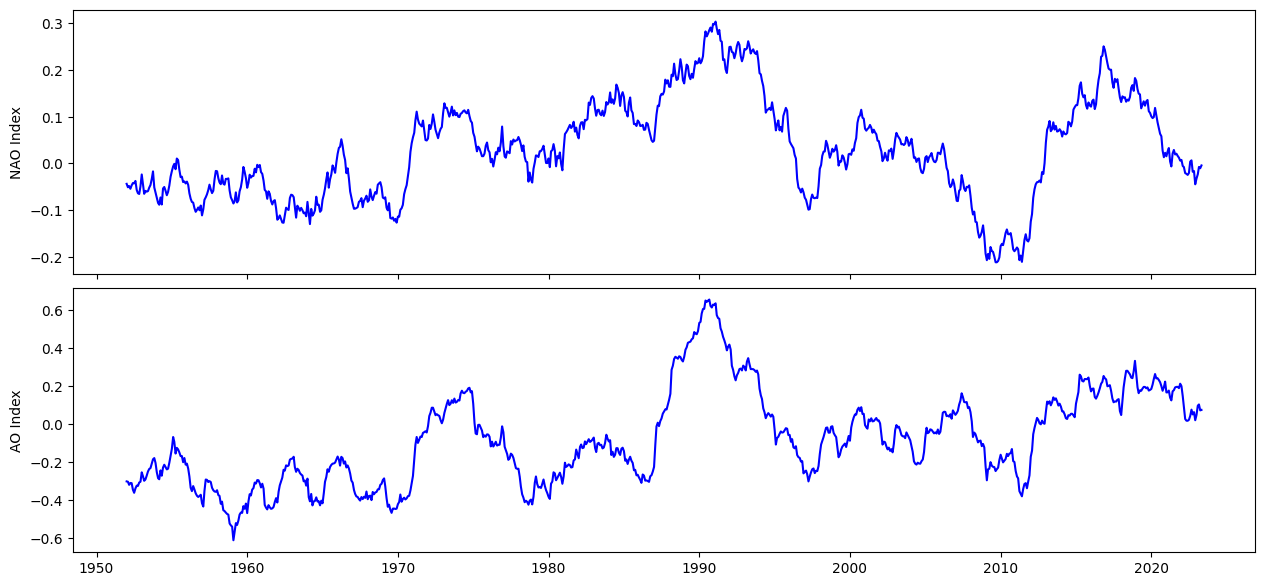

In [10]:
df = atmos.resample("MS").mean().rolling(48, center = True).mean()

nrows = 2
ncols = 1
squish_factor = 2
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].plot(
    df["nao"],
    c = "blue",
)
ax[0].set_ylabel("NAO Index")

sp1 = ax[1].plot(
    df["ao"],
    c = "blue",
)
ax[1].set_ylabel("AO Index")

Climate Variables for Abisko

Text(0, 0.5, 'Daily Snow depth (cmd-1)')

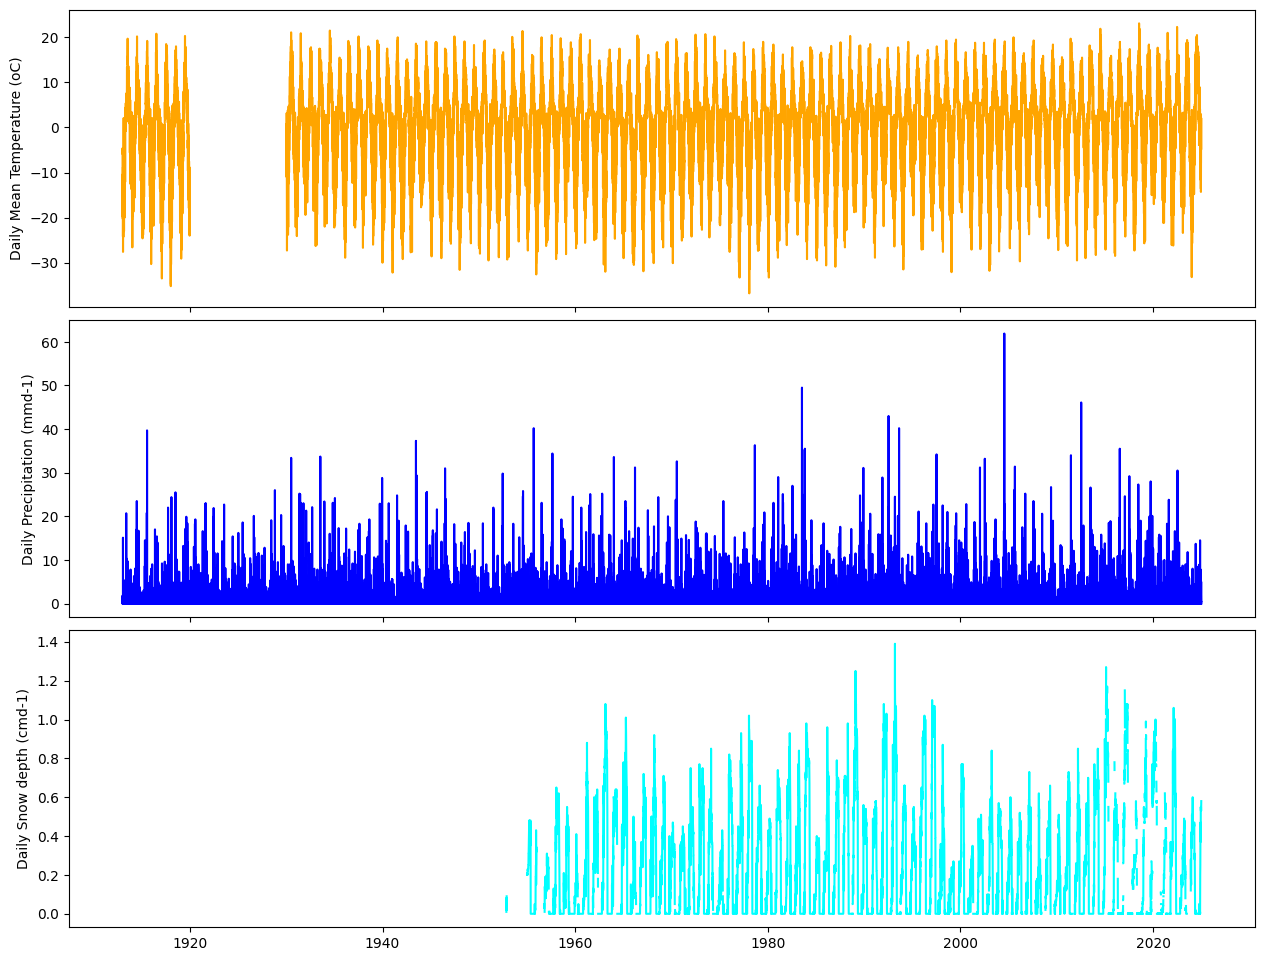

In [12]:
df = se_sto_clim#.resample("MS").mean().rolling(12, center = True, min_periods = 8).mean()

nrows = 3
ncols = 1
squish_factor = 6
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].plot(
    df["temperature"],
    c = "orange",
)
ax[0].set_ylabel("Daily Mean Temperature (oC)")

sp1 = ax[1].plot(
    df["precipitation"],
    c = "blue",
)
ax[1].set_ylabel("Daily Precipitation (mmd-1)")

sp2 = ax[2].plot(
    df["snowdepth"],
    c = "cyan",
)
ax[2].set_ylabel("Daily Snow depth (cmd-1)")

# Export

In [13]:
atmos.to_csv(f"../data/processed/atmos.csv")
se_sto_clim.to_csv(f"../data/processed/se_st1_climate.csv")
se_sto_clim.to_csv(f"../data/processed/se_sto_climate.csv")
fi_ken_clim.to_csv(f"../data/processed/fi_ken_climate.csv")
fi_sod_clim.to_csv(f"../data/processed/fi_sod_climate.csv")
fi_var_clim.to_csv(f"../data/processed/fi_var_climate.csv")